#  1. Importações e dados.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
import joblib

from imblearn.over_sampling import SMOTE, SMOTENC
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('/home/fause/ML-Transportes/PBIC/Etapa3/acidentes_pbic_2020_2025_Final.csv', encoding="utf-8", parse_dates=['data_inversa'], dayfirst=True, low_memory=False)
print('Linhas, colunas:', df.shape)

# Exibir as primeiras linhas
df.head()


Linhas, colunas: (1678326, 48)


,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,...,mes,dia_mes,hora,gravidade_numerica,total_vitimas,Marca_Principal,Modelo_Grupo,Nome_Modelo,Fabricante,Modelo
0,260031.0,578475.0,2020-01-01,quarta-feira,01:00:00,TO,153.0,"678,1",GURUPI,Sim,...,1,1,1,2,1.0,FIAT,SIENA ATTRACTIV 1.4/SIENA ATTRACTIV 1.4,SIENA,FIAT,SIENA
1,260031.0,578475.0,2020-01-01,quarta-feira,01:00:00,TO,153.0,"678,1",GURUPI,Sim,...,1,1,1,2,1.0,FIAT,SIENA ATTRACTIV 1.4/SIENA ATTRACTIV 1.4,SIENA,FIAT,SIENA
2,260036.0,582005.0,2020-01-01,quarta-feira,01:00:00,RJ,116.0,178,NOVA IGUACU,Não,...,1,1,1,0,1.0,Não Informado,Não Informado/Não Informado,NO,Não Informado,NO
3,260036.0,582005.0,2020-01-01,quarta-feira,01:00:00,RJ,116.0,178,NOVA IGUACU,Sim,...,1,1,1,0,1.0,Não Informado,Não Informado/Não Informado,NO,Não Informado,NO
4,260037.0,578473.0,2020-01-01,quarta-feira,01:52:00,SC,101.0,"206,9",SAO JOSE,Sim,...,1,1,1,0,1.0,VW,NOVA SAVEIRO RB MBVS/NOVA SAVEIRO RB MBVS,NOVA,VOLKSWAGEN,NOVA


In [3]:
# Filtrar Fabricante inválido
df = df[df["Fabricante"] != "Não Informado"]

# Remover ano inválido
df = df[df["ano_fabricacao_veiculo"] > 1900]  # filtro simples

df.shape

(1549666, 48)

# 2) Criar target binário 'grave'

In [4]:
if 'gravidade_numerica' not in df.columns:
    raise ValueError('Coluna gravidade_numerica não encontrada no dataset')

In [5]:
print('Percentual de NA em gravidade_numerica:', df['gravidade_numerica'].isna().mean())

Percentual de NA em gravidade_numerica: 0.0


In [6]:
df = df.dropna(subset=['gravidade_numerica'])


df['grave'] = (df['gravidade_numerica'] >= 2).astype(int) # 1 se grave (2|feridos graves| ou 3|Mortos|), 0 se não grave (0 ou 1)
print('Distribuição target:', df['grave'].value_counts(normalize=True))

Distribuição target: grave
0    0.825981
1    0.174019
Name: proportion, dtype: float64


3) Análises descritivas rápidas (identificar fabricantes/modelos/anos mais envolvidos em acidentes graves)

In [7]:
# Top fabricantes por número absoluto de acidentes graves
top_fabricantes_graves = (
df[df['grave'] == 1]
.groupby('Fabricante')
.size()
.sort_values(ascending=False)
.head(20)
)
print('Top 20 fabricantes em acidentes graves:', top_fabricantes_graves)



Top 20 fabricantes em acidentes graves: Fabricante
HONDA            117478
VOLKSWAGEN        23604
YAMAHA            21183
FIAT              20601
CHEVROLET         17512
MERCEDES-BENZ     10103
FORD               8981
SCANIA             7583
VOLVO              6734
TOYOTA             5194
RENAULT            4817
HYUNDAI            2989
SUZUKI             2796
IVECO              2308
BMW                1867
KAWASAKI           1477
PEUGEOT            1271
MITSUBISHI         1249
NISSAN              964
SHINERAY            952
dtype: int64


In [8]:

# Top modelos por número absoluto de acidentes graves
top_modelos_graves = (
df[df['grave'] == 1]
.groupby('Modelo')
.size()
.sort_values(ascending=False)
.head(20)
)
print('Top 20 modelos em acidentes graves:', top_modelos_graves)

Top 20 modelos em acidentes graves: Modelo
CG        60360
BIZ        8949
GOL        7456
NXR150     7090
CG150      6285
UNO        5790
NXR160     5577
CB         5080
FH         4779
PALIO      4314
STRADA     3851
XRE        3817
CBX        2977
POP        2890
L          2688
FACTOR     2654
TOYOTA     2608
CORSA      2473
SUZUKI     2411
YBR        2204
dtype: int64


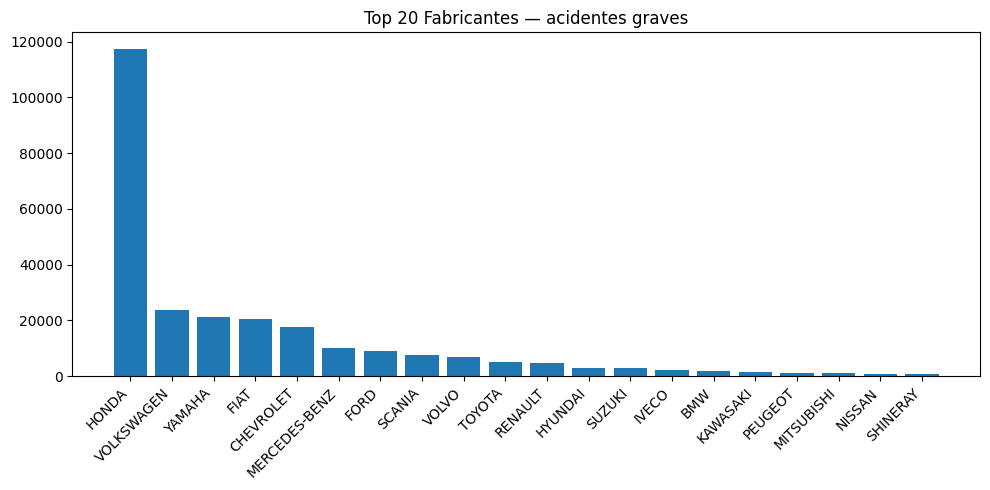

In [9]:
# Visualizações simples
plt.figure(figsize=(10,5))
plt.bar(top_fabricantes_graves.index, top_fabricantes_graves.values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Fabricantes — acidentes graves')
plt.tight_layout()
plt.show()

# 4) Preparar dados para ML

In [10]:
features = [
    "tipo_veiculo",
    "Fabricante",
    "Modelo",
    "ano_fabricacao_veiculo"
]

In [11]:
X = df[features]
y = df["grave"]  # Usar target binário (0 = não grave, 1 = grave)

In [12]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [13]:
# 2. Calcular peso de classe (substitui SMOTE)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale = neg / pos
print("scale_pos_weight:", scale)

# 3. Pipeline encoder + modelo
preprocessador = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"),
         ["tipo_veiculo", "Fabricante", "Modelo"]),
        ("num", "passthrough", ["ano_fabricacao_veiculo"])
    ]
)

scale_pos_weight: 4.746496892049115


# 8. TREINAR XGBOOST

In [14]:
modelo = Pipeline([
    ("prep", preprocessador),
    ("clf", XGBClassifier(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        n_jobs=-1,
        scale_pos_weight=scale,
        gamma=5,
        reg_alpha=0.5,    # L1
        reg_lambda=1.0    # L2
    ))
])

# 4. Treinar
modelo.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 9. AVALIAÇÃO DO MODELO

In [15]:
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83    255999
           1       0.34      0.57      0.43     53935

    accuracy                           0.74    309934
   macro avg       0.62      0.67      0.63    309934
weighted avg       0.80      0.74      0.76    309934

ROC AUC: 0.7113271713007399
